# Option pricing 

In this notebook I write the code to evaluate option price, compare it with the market prices and calculate implied volatility

#### Valuation by means of the binomial tree

This approach is based on the idea, that the option contract can be replicated by some other assets at any time t - and by no arbitrage principle the value of such a portfolio would equal the contract value. The calculation involves the creation of the so-called binomial tree, i.e., movement of the stock in period t+1: $S_{t+1} = S_t * u$ and $S_{t+1} = S_t * d$, with u and d below. The risk-neutral probability q is used to discount the option value. More detailed explaination can be found in "Options, Futures and Other Derivatives" by Pearson, Prentice Hall.

$$u \approx e^{\sigma\sqrt{\Delta t}}$$

$$d \approx e^{-\sigma\sqrt{\Delta t}}$$

$$q = \frac{e^{r\Delta t} - d}{u - d}$$

In [56]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import pandas_datareader.data as web
from IPython.display import display, Latex
import matplotlib.pyplot as plt

In [57]:
class Pricing:
    def __init__(self, starting_share_price, T, t, sigma, risk_free):
        """
Function to price an option using the binomial tree valuation method.

Parameters:
- starting_share_price (float): The current price of the underlying asset.
- T (float): The time to expiration of the option, measured in years.
- t (int): The number of periods into which the time to expiration is divided. 
           A higher value of t increases accuracy but also computational cost.
- sigma (float): The volatility of the underlying asset (standard deviation of returns).
- risk_free (float): The risk-free interest rate, typically the yield on government bonds.

Functions:
- .tree: Returns a binomial tree representing the valuation of the option at each node.
- .option_pricing: Returns the option price given the binomial tree
- .implied_volatility: Returns the implied volatility of the option, given its market price 

        """
        self.starting_share_price = starting_share_price
        self.t = t
        self.T = T
        self.sigma = sigma
        self.rf = risk_free
        
        self.delta_t = T / t
        self.u = np.exp(self.sigma * np.sqrt(self.delta_t))
        self.d = 1 / self.u
        self.D = np.exp(-self.rf * self.delta_t)
        self.q = (1 / self.D - self.d) / (self.u - self.d)
        self.Tree = None
        self.K = None
        self.ret = None
        self.option_return = None
        self.par1 = None
        self.par2 = None 
        self.par3 = None
        self.val = None

    def tree(self):
        '''
Returns a binomial tree representing the valuation of the option at each node.        
        '''
        levels = np.arange(self.t + 1)
        Tree = np.zeros((self.t + 1, self.t + 1))
        for i in range(self.t + 1):
            Tree[:i + 1, i] = self.starting_share_price * (self.u ** (i - levels[:i + 1])) * (self.d ** levels[:i + 1])
        self.Tree = Tree
        return self.Tree

    def option_pricing(self, K, option_type, american = "No", return_full_tree = "No"):
        '''
Returns the option price given the binomial tree.  

Parameters:
- K (float): The strike price.
- option_type (string): Type of the option ('Call' or 'Put') 
- american (string): Whether the option is American ("Yes" or "No"). "No" by default
- return_full_tree (string): Whether to return the full tree ("Yes" or "No"). "No" by default
        '''    
        
        if option_type not in ["Call", "Put"]:
            raise ValueError(f"Invalid option_type. Expected one of ['Call', 'Put'], got '{option_type}'.")
            
        if american not in ["Yes", "No"]:
            raise ValueError(f"Invalid american. Expected one of ['Yes', 'No'], got '{american}'.")
        
        if return_full_tree not in ["Yes", "No"]:
            raise ValueError(f"Invalid return_full_tree. Expected one of ['Yes', 'No'], got '{return_full_tree}'.")
        
        self.par1 = option_type
        self.par2 = american 
        self.par3 = return_full_tree 
        
        self.K = K
        self.ret = np.maximum(self.Tree - self.K, 0) if option_type == "Call" else np.maximum(self.K - self.Tree, 0)
        self.option_return = self.ret[:, -1]  # Payoff at expiration

        t = self.Tree.shape[0] - 1
        FullTree = np.zeros_like(self.Tree)
        FullTree[:, -1] = self.option_return

        for j in range(t - 1, -1, -1):
            for i in range(j + 1):
                continuation_value = self.D * (self.q * FullTree[i, j + 1] + (1 - self.q) * FullTree[i + 1, j + 1])
                FullTree[i, j] = continuation_value if american == "No" else max(continuation_value, self.ret[i, j])

        self.FullTree = FullTree
        self.val = round(FullTree[0, 0],2)
        
        return FullTree if return_full_tree == "Yes" else round(FullTree[0, 0],2)
        
    
    def implied_volatility(self, opt_price):
        '''
Returns the implied volatility of the option, given its market price

Parameters:
- opt_price(float): market price of the option
        '''
        val = self.val
        sigma = self.sigma
        
        while val != np.ceil(opt_price):
            pricing = Pricing(self.starting_share_price, self.T, self.t, sigma, self.rf)
            pricing.tree()       
            val = np.ceil(pricing.option_pricing(self.K, self.par1, self.par2, self.par3))
            if val > opt_price: sigma*=0.9975
            if val < opt_price: sigma*=1.0025        
        
        return round(sigma, 2)

Check the functionality on a theoretical example:

In [59]:
S0 = 55 #current share price
K = 60 #strike price
T = 5/12 #5 months till maturity
t = 5 #5 periods in a binomial tree
sigma = 0.25 #volatility
rf = 0.03 # risk-free rate

share1 = Pricing(S0, T, t, sigma, rf)
Tree = share1.tree()
print(Tree) #print the binomial tree

[[55.         59.1160209  63.5400714  68.29520343 73.40619406 78.89967459]
 [ 0.         51.17056179 55.         59.1160209  63.5400714  68.29520343]
 [ 0.          0.         47.60775261 51.17056179 55.         59.1160209 ]
 [ 0.          0.          0.         44.29300812 47.60775261 51.17056179]
 [ 0.          0.          0.          0.         41.20905652 44.29300812]
 [ 0.          0.          0.          0.          0.         38.3398286 ]]


In [60]:
print(share1.option_pricing(K, "Put", return_full_tree = "Yes")) #print the complete valuation of the European put option

[[ 6.10843087  3.49720051  1.4295681   0.22051506  0.          0.        ]
 [ 0.          8.74282179  5.5764751   2.6423523   0.44150958  0.        ]
 [ 0.          0.         11.94393068  8.53018696  4.85018734  0.8839791 ]
 [ 0.          0.          0.         15.40774063 12.24243473  8.82943821]
 [ 0.          0.          0.          0.         18.64113082 15.70699188]
 [ 0.          0.          0.          0.          0.         21.6601714 ]]


In [61]:
print(share1.option_pricing(K, "Call", american = "Yes")) #print the valuation of the American call option

1.85


Now let's compare this theoretical pricing with a real-life example: 

In [63]:
ticker = 'NVDA'
end = datetime.datetime.today()
start = end - datetime.timedelta(days=365)
stock = yf.download(ticker, start=start, end=end)['Adj Close']
S0 = stock.iloc[-1]
print(f'Current stock price is: ${S0:.2f}')

[*********************100%%**********************]  1 of 1 completed

Current stock price is: $136.92


check expiration dates:

In [65]:
exp_dates = yf.Ticker(ticker).options
exp_dates

('2024-11-29',
 '2024-12-06',
 '2024-12-13',
 '2024-12-20',
 '2024-12-27',
 '2025-01-03',
 '2025-01-17',
 '2025-02-21',
 '2025-03-21',
 '2025-04-17',
 '2025-05-16',
 '2025-06-20',
 '2025-08-15',
 '2025-09-19',
 '2025-12-19',
 '2026-01-16',
 '2026-06-18',
 '2026-09-18',
 '2026-12-18',
 '2027-01-15')

decide on the duraion:

In [67]:
dur =  datetime.timedelta(days=365) #12 months
exp_date = str([i.date() for i in pd.to_datetime(exp_dates) if i>(end + dur)][0]) #pick the earliest option

option_type = 'Put' #"Put" or "Call"
P = yf.Ticker(ticker).option_chain(exp_date).puts if option_type == "Put" else (yf.Ticker('NVDA').option_chain(exp_date).calls if option_type == "Call" else 0)
K = np.ceil(S0)+1
P = P[(P['strike'] > K) & (P['strike'] < K*1.1)]
P

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
201,NVDA251219P00140000,2024-11-26 20:00:21+00:00,140.0,25.62,0.0,0.0,0.0,0.0,8.0,2598,0.00001,True,REGULAR,USD
202,NVDA251219P00142000,2024-11-25 18:00:39+00:00,142.0,26.85,0.0,0.0,0.0,0.0,25.0,766,0.00001,True,REGULAR,USD
203,NVDA251219P00144000,2024-11-25 16:48:56+00:00,144.0,27.70,0.0,0.0,0.0,0.0,10.0,220,0.00001,True,REGULAR,USD
204,NVDA251219P00145000,2024-11-26 16:57:50+00:00,145.0,28.43,0.0,0.0,0.0,0.0,7.0,2799,0.00001,True,REGULAR,USD
205,NVDA251219P00146000,2024-11-25 16:49:38+00:00,146.0,29.05,0.0,0.0,0.0,0.0,15.0,353,0.00001,True,REGULAR,USD
206,NVDA251219P00148000,2024-11-26 15:00:54+00:00,148.0,30.51,0.0,0.0,0.0,0.0,1.0,186,0.00001,True,REGULAR,USD
207,NVDA251219P00150000,2024-11-26 19:26:36+00:00,150.0,31.91,0.0,0.0,0.0,0.0,37.0,1736,0.00001,True,REGULAR,USD


In [68]:
# we choose the most traded option
P = P[P['openInterest'] == max(P['openInterest'])]
P0 = P['lastPrice'].iloc[0]
K = P['strike'].iloc[0]
print(f"Closing price for the put option: {P0} \
        \nStrike price: {K}")

Closing price for the put option: 28.43         
Strike price: 145.0


In [69]:
rf = web.DataReader("DTB6", "fred", start, end).values.ravel()[-1]/100 #download risk-free rate
print(f'risk-free US interest rate: {rf: .2%}')
rf = np.log(1+rf) #continuously compounded interest

risk-free US interest rate:  4.34%


The time to expiration T , measured in years, assuming that a year consists of 252 trading days

In [71]:
# Assume that the number of trading days was the same a year ago
s = pd.Timestamp('today').normalize() - pd.DateOffset(years=1)
e = pd.Timestamp(exp_date) - pd.DateOffset(years=1)

T = len(yf.download(ticker, start=s, end=e)['Adj Close'])/252
print(f'time to expiration T: {T:.2f}')

[*********************100%%**********************]  1 of 1 completed

time to expiration T: 1.00


An estimate of σ, the per annum stock return volatility

In [73]:
s_return = (np.log(stock) - np.log(stock).shift(1)).dropna()
sigma = np.std(s_return)*np.sqrt(252)
display(Latex(f'$\sigma$ : {sigma:.2f}'))

<IPython.core.display.Latex object>

In [74]:
array = pd.Series()

for t in range(2,100):  
    share = Pricing(S0, T, t, sigma, rf)
    Tree = share.tree()
    option_price = share.option_pricing(K, option_type)
    array[t] = option_price

Also calculate the Black-Scholes value of the option

In [76]:
d1 = (np.log(S0 / K) + (rf + sigma**2/2)*T) / (sigma * np.sqrt(T))
d2 = d1  - (sigma * np.sqrt(T))
N_d1 = norm.cdf(-d1) if option_type == "Put" else norm.cdf(d1)
N_d2 = norm.cdf(-d2) if option_type == "Put" else norm.cdf(d2)

option =  K*np.exp(-rf * T)*N_d2 - S0*N_d1 if option_type == "Put" else S0 * N_d1 - K * np.exp(-rf * T) * N_d2


print(f'Option price is: ${option:.2f}')

Option price is: $29.25


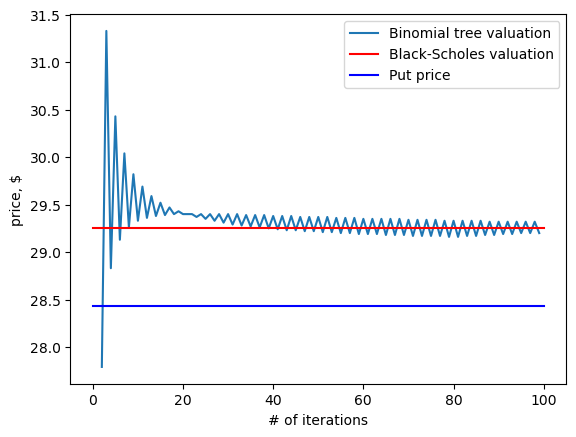

In [77]:
array.plot(label = 'Binomial tree valuation')
plt.plot(np.linspace(0, 100), [option]*len(np.linspace(0, 100)), color = 'red', label = 'Black-Scholes valuation')
plt.plot(np.linspace(0, 100), [P0]*len(np.linspace(0, 100)),'b', label = 'Put price')
plt.legend()
plt.xlabel('# of iterations')
plt.ylabel('price, $')
plt.show()

Obviously, binomial tree valuation converges to the Black Scholes price, but both (theoretical) values are different from the market price.

Let's calculate the implied volatility

In [79]:
share.implied_volatility(P0)

0.51

Sanity check:

In [81]:
share = Pricing(S0, T, t, 0.51, rf)
share.tree()
share.option_pricing(K, option_type)

28.8